In [1]:
image_paths = [
    '/export/space0/tanabe-h/data/animal/cat/458000.jpg',
    '/export/space0/tanabe-h/data/animal/dog/415000.jpg',
    '/export/space0/tanabe-h/data/animal/elephant/107000.jpg',
    '/export/space0/tanabe-h/data/animal/fish/209005.jpg',
    '/export/space0/tanabe-h/data/animal/penguin/541001.jpg',
]
true_labels = [281, 194, 386, 395, 145]

/home/yanai-lab/tanabe-h/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yanai-lab/tanabe-h/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/yanai-lab/tanabe-h/miniconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to ge

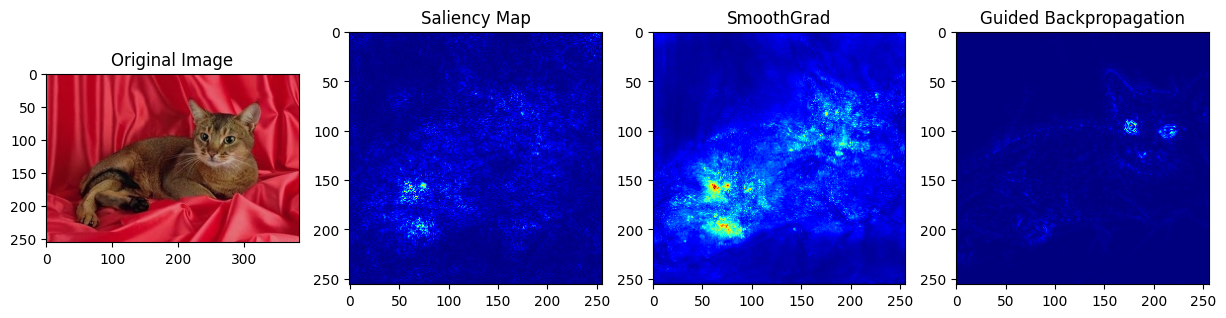

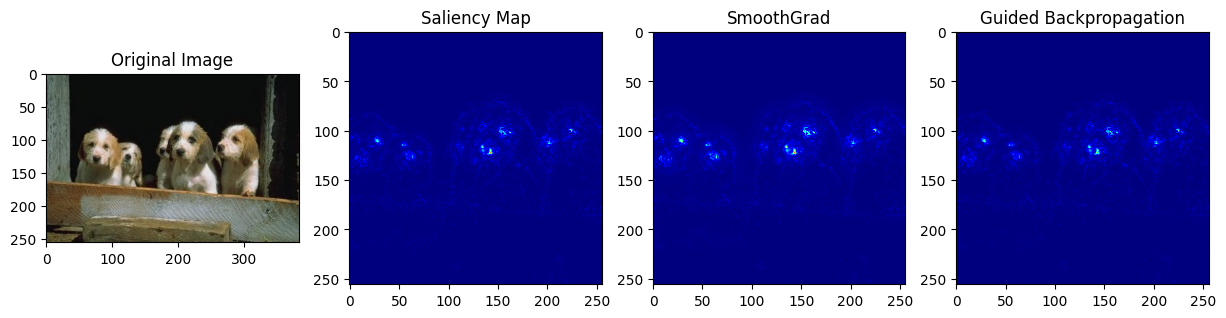

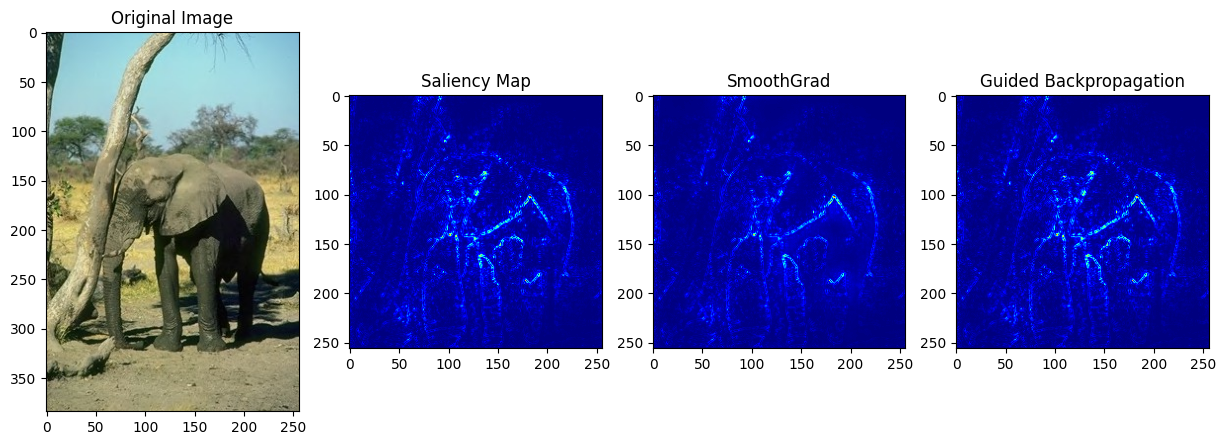

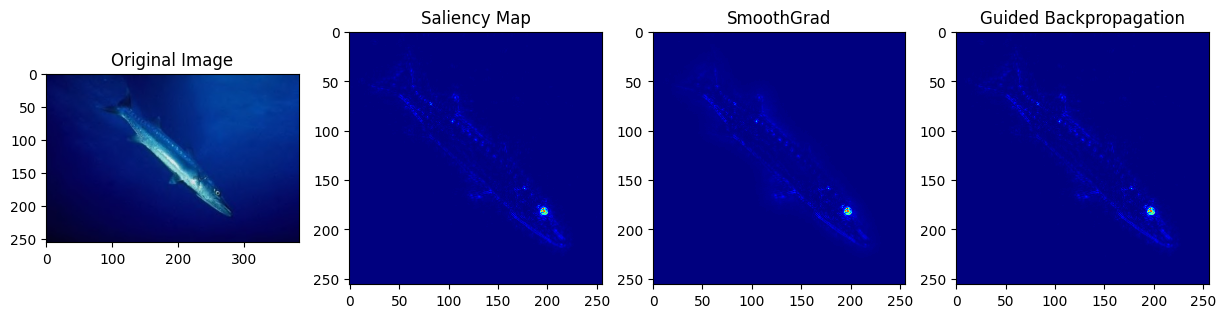

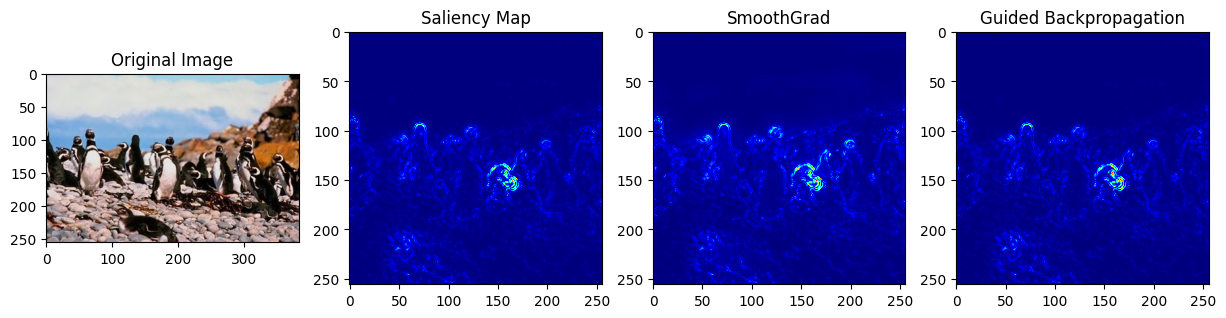

In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load pre-trained VGG16 model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Data transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def create_saliency_map(image_path, target_label):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    img_tensor.requires_grad_(True)
    
    # Forward pass and calculate gradients
    output = model(img_tensor)
    loss = F.nll_loss(output, torch.tensor([target_label]))
    model.zero_grad()
    loss.backward()

    # Create saliency map
    saliency_map = img_tensor.grad.squeeze().abs().max(dim=0)[0].detach().numpy()
    return saliency_map

def create_smoothgrad(image_path, target_label, n_samples=50, noise_level=0.1):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    
    grads = []
    for _ in range(n_samples):
        noisy_img = img_tensor + noise_level * torch.randn_like(img_tensor)
        noisy_img.requires_grad_(True)
        output = model(noisy_img)
        loss = F.nll_loss(output, torch.tensor([target_label]))
        model.zero_grad()
        loss.backward()
        grads.append(noisy_img.grad.squeeze().abs().max(dim=0)[0].detach().numpy())
    
    smoothgrad = np.mean(grads, axis=0)
    return smoothgrad

def create_guided_bp(image_path, target_label):
    def guided_bp_hook(module, grad_in, grad_out):
        if isinstance(module, torch.nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
    
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    img_tensor.requires_grad_(True)
    
    for module in model.features:
        if isinstance(module, torch.nn.ReLU):
            module.register_backward_hook(guided_bp_hook)
    
    output = model(img_tensor)
    loss = F.nll_loss(output, torch.tensor([target_label]))
    model.zero_grad()
    loss.backward()
    
    guided_bp = img_tensor.grad.squeeze().abs().max(dim=0)[0].detach().numpy()
    return guided_bp

for i, (image_path, true_label) in enumerate(zip(image_paths, true_labels)):
    saliency_map = create_saliency_map(image_path, true_label)
    smoothgrad = create_smoothgrad(image_path, true_label)
    guided_bp = create_guided_bp(image_path, true_label)

    img = Image.open(image_path).convert("RGB")
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 4, 2)
    plt.imshow(saliency_map, cmap='jet')
    plt.title("Saliency Map")

    plt.subplot(1, 4, 3)
    plt.imshow(smoothgrad, cmap='jet')
    plt.title("SmoothGrad")

    plt.subplot(1, 4, 4)
    plt.imshow(guided_bp, cmap='jet')
    plt.title("Guided Backpropagation")

    plt.show()